In [5]:
import numpy as np
import tensorflow as tf

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import json
import pickle
from sklearn.externals import joblib

In [6]:
from TensorRing_Machine import TensorRing_Machine, simple_batcher
from numpy import load


In [7]:
import numpy as np
import tensorflow as tf

import json
import pickle
from sklearn.externals import joblib

from TensorRing_Machine import TensorRing_Machine, simple_batcher
from numpy import load

X_tr=load('x_train.npy')
X_te=load('x_test.npy')
y_tr=load('y_train.npy')
y_te=load('y_test.npy')


#%%
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
oh = OneHotEncoder()
oh.fit(np.vstack((X_tr, X_te))-1)
X_tr_sp = oh.transform(X_tr-1)
X_te_sp = oh.transform(X_te-1)
logreg = LogisticRegression()
logreg.fit(X_tr_sp, y_tr)
y_pred = logreg.predict_proba(X_te_sp)[:, 1]
print(roc_auc_score(y_te, y_pred))
#%%
target_rank = 10
s_features=[7,2,21,19,943,1682,10,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]

num_features = len(s_features)
w_cores = [None] * num_features

coef = logreg.coef_[0]
intercept = logreg.intercept_[0]

# see paper for details about initialization
begin_feature = [0] + list(np.cumsum(s_features))
for i in range(num_features):
    n_factors = s_features[i] # n factors is d 
    if i == 0:
        tmp = np.zeros((n_factors+1, target_rank, target_rank)) # dxmxm
        for local_j, global_j in enumerate([-1] + list(range(begin_feature[i], s_features[i]))):
            if local_j==0:
                tmp[local_j,:1,:2] = [1, 0]
            else:
                tmp[local_j,:1,:2] = [0, coef[global_j]]
        w_cores[i] = tmp.astype(np.float32)
            
    elif i == num_features-1:
        tmp = np.zeros((n_factors+1, target_rank, target_rank))
        for local_j, global_j in enumerate([-1] + list(range(begin_feature[i], s_features[i]))):
            if local_j==0:
                tmp[local_j,:2,:1] = np.array([[intercept], [1]])
            else:
                tmp[local_j,:2,:1] = [[coef[global_j]], [0]]
        w_cores[i] = tmp.astype(np.float32)
            
    else:
        tmp = np.zeros((n_factors+1, target_rank, target_rank))
        for local_j, global_j in enumerate([-1] + list(range(begin_feature[i], s_features[i]))):
            if local_j==0:
                tmp[local_j,:2,:2] = np.eye(2)
            else:
                tmp[local_j,:2,:2] = [[0, coef[global_j]], [0,0]]
        w_cores[i] = tmp.astype(np.float32)
        
        
#%%
model = TensorRing_Machine(rank=target_rank, s_features=s_features, init_std=0.001, reg=0.012, exp_reg=1.8)
model.init_from_cores(w_cores)
model.build_graph()
model.initialize_session()

epoch_hist = []
for epoch in range(101):
    # train phase
    loss_hist = []
    penalty_hist = []
    for x, y in simple_batcher(X_tr, y_tr, 256):
        fd = {model.X: x, model.Y: 2*y-1}
        run_ops = [model.trainer, model.outputs, model.loss, model.penalty]
        _, outs, batch_loss, penalty = model.session.run(run_ops, fd)
        loss_hist.append(batch_loss)
        penalty_hist.append(penalty)
    epoch_train_loss = np.mean(loss_hist)
    epoch_train_pen = np.mean(penalty_hist)
    
    epoch_stats = {
        'epoch': epoch,
        'train_logloss': float(epoch_train_loss)
    }
    
    # test phase
    if epoch%2==0 and epoch>0:
        fd = {model.X: X_te, model.Y: 2*y_te-1}
        run_ops = [model.outputs, model.loss, model.penalty, model.penalized_loss]
        outs, raw_loss, raw_penalty, loss = model.session.run(run_ops, fd)
        epoch_test_loss = roc_auc_score(y_te, outs)
        epoch_stats['test_auc'] = float(epoch_test_loss),
        epoch_stats['penalty'] = float(raw_penalty)
        print('{}: te_auc: {:.4f}'.format(epoch, epoch_test_loss))
    epoch_hist.append(epoch_stats)
    
        

/opt/anaconda3/envs/Datathon2019/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/Datathon2019/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7821230253636114
2: te_auc: 0.7664
4: te_auc: 0.7717
6: te_auc: 0.7754
8: te_auc: 0.7772
10: te_auc: 0.7778
12: te_auc: 0.7789
14: te_auc: 0.7801
16: te_auc: 0.7808
18: te_auc: 0.7811
20: te_auc: 0.7812
22: te_auc: 0.7813
24: te_auc: 0.7814
26: te_auc: 0.7815
28: te_auc: 0.7815
30: te_auc: 0.7815
32: te_auc: 0.7814
34: te_auc: 0.7815
36: te_auc: 0.7817
38: te_auc: 0.7822
40: te_auc: 0.7826
42: te_auc: 0.7827
44: te_auc: 0.7827
46: te_auc: 0.7827
48: te_auc: 0.7827
50: te_auc: 0.7827
52: te_auc: 0.7826
54: te_auc: 0.7826
56: te_auc: 0.7826
58: te_auc: 0.7826
60: te_auc: 0.7826
62: te_auc: 0.7826
64: te_auc: 0.7826
66: te_auc: 0.7826
68: te_auc: 0.7826
70: te_auc: 0.7826
72: te_auc: 0.7826
74: te_auc: 0.7826
76: te_auc: 0.7826
78: te_auc: 0.7827
80: te_auc: 0.7826
82: te_auc: 0.7826
84: te_auc: 0.7826
86: te_auc: 0.7826
88: te_auc: 0.7826
90: te_auc: 0.7826
92: te_auc: 0.7826
94: te_auc: 0.7825
96: te_auc: 0.7825
98: te_auc: 0.7825
100: te_auc: 0.7825


Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'test auc')

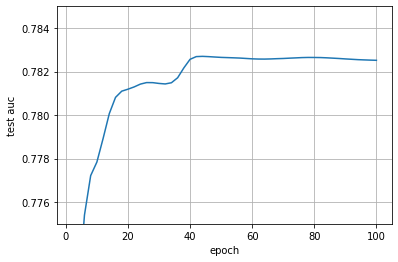

In [8]:
%pylab inline
plot([x['epoch'] for x in epoch_hist if 'test_auc' in x], [x['test_auc'] for x in epoch_hist if 'test_auc' in x])
grid()
ylim(0.775, 0.785)
xlabel('epoch')
ylabel('test auc')